# Classification and Ensemble models


In [31]:
pip install wget

In [32]:
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Part 0: Prep Work
- Load data: Read the CSV into a Pandas DataFrame named df.
- Inspect data: Print the first rows to examine features and targets (df.head()).
- Identify target: The target column to predict is is_genuine.
- Feature count: There are 6 input features used to predict the target.
- Create binary target: Add a new column target with 1 if is_genuine is True, else 0.

In [33]:
myfile = wget.download('https://raw.githubusercontent.com/Sabaae/Dataset/main/modified_fake_bills.csv')
df = pd.read_csv(myfile, delimiter=',')

In [34]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,515.43,104.86,104.95,4.52,2.89,112.83
1,True,514.38,103.36,103.66,3.77,2.99,113.09
2,True,518.07,104.48,103.50,4.40,2.94,113.16
3,True,514.08,103.91,103.94,3.62,3.01,113.51
4,True,515.19,104.28,103.46,4.04,3.48,112.54


In [35]:
### YOUR CODE HERE ###
df['target'] = np.where(df['is_genuine'] == True, 1, 0)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,target
0,True,515.43,104.86,104.95,4.52,2.89,112.83,1
1,True,514.38,103.36,103.66,3.77,2.99,113.09,1
2,True,518.07,104.48,103.50,4.40,2.94,113.16,1
3,True,514.08,103.91,103.94,3.62,3.01,113.51,1
4,True,515.19,104.28,103.46,4.04,3.48,112.54,1


# Part A: Pre-processing 

### Data Cleaning

* Each row in the dataset represents the physical measurements of a single banknote (paper money).

* The columns include various dimensions of the banknote:

  * Diagonal
  * Left height
  * Right height
  * Lower margin
  * Upper margin
  * Total length

* The **`is_genuine`** column indicates whether the banknote is genuine or counterfeit.

* Check the dataset for missing values.

* If any missing values are found, delete the entire row.

* Report how many samples (rows) are dropped.

* Report the size of the dataset after cleaning:

  * Number of rows
  * Number of columns

In [36]:
### YOUR CODE HERE ###
print("Missing Values: ")
print(df.isna().sum())
df = df.dropna(axis=0, how = "any")
print("Missing Values after Dropping: ")
print(df.isna().sum())
print("Size of Dataset: ", df.shape)

Missing Values: 
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
target           0
dtype: int64
Missing Values after Dropping: 
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
target          0
dtype: int64
Size of Dataset:  (1463, 8)


### Final Clean Up Before Splitting

* The goal is to eventually obtain the best possible accuracy on the test set.

* All model tuning will be done using the training and validation sets.

* It is best practice to split the data into:

  * A training set (with a rotating validation subset)
  * A test set

* Before splitting the dataset (which will be done in Part A3), perform final data cleanup steps.

* Refer to the scikit-learn `train_test_split` example provided in the documentation.

* In `train_test_split`:

  * The first argument is **X**:

    * The feature values used to make predictions
  * The second argument is **y**:

    * The target variable we want to predict

* Prepare the variables:

  * **X** should contain only the feature columns
  * **y** should contain the target column

In [37]:
### YOUR CODE HERE ###
X = df.drop(['is_genuine', 'target'], axis = 1)
Y = df['target']

### Data Splitting 

* The goal was to maximize test-set accuracy while performing all tuning on training and validation data.

* Feature variables (**X**) were constructed from the banknote measurement columns, and the target variable (**y**) represented banknote authenticity.

* The dataset was split **once** into training and test sets using an **80:20** ratio with **random_state = 24** to ensure reproducibility.

* The test set was held out and used only for final model evaluation, following standard machine learning best practices.


In [38]:
### YOUR CODE HERE ###
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

### Effect of Standardization (Visual)
* A scatter plot of the training data was created using `seaborn.lmplot`, with **height_left** on the x-axis and **diagonal** on the y-axis, and points colored by class.

* The same plot was generated after standardizing both features.

* The two plots appear nearly identical because standardization is a linear scaling that preserves relative relationships and correlations between features.

* While standardization does not change the visual structure, it improves model training by placing features on the same scale, which benefits distance- and gradient-based algorithms and improves numerical stability.

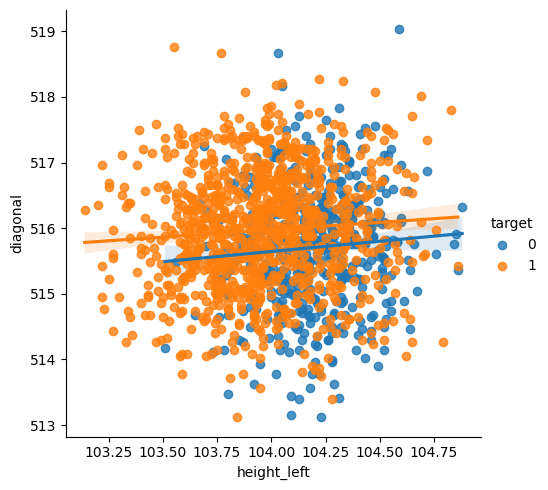

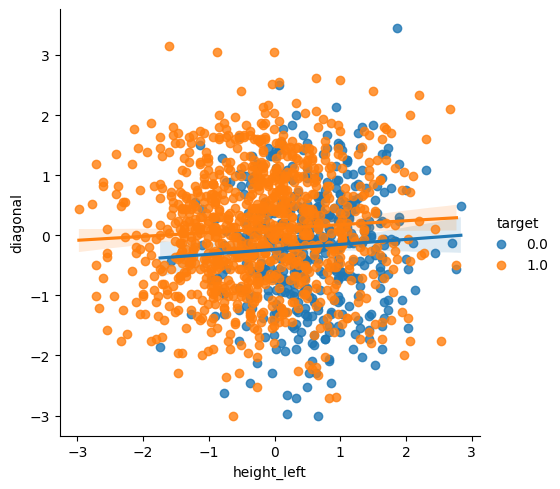

In [39]:
### YOUR CODE HERE ###
import seaborn as sns
#1) First Plot Unstandardized
sns.lmplot(x="height_left", y="diagonal", data=df, hue="target")

#2) Second Plot Standardized
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = df.drop(['target', 'is_genuine'], axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
scaled_df['target'] = df['target']
sns.lmplot(x="height_left", y="diagonal", data=scaled_df, hue="target")

# Part B: K - Nearest Neighbour

### KNN Model with Standardization

* A **KNN classifier** was built to predict banknote authenticity from physical measurements.

* Features were standardized using a **StandardScaler fit only on the training set**, then applied to both training and test data to avoid data leakage.

* A **10-fold cross-validation** sweep was performed for **k = 1 to 90**, and mean validation accuracy was plotted against *k*.

* The best **k** was selected based on the **highest cross-validation accuracy**.

* **Small k values** showed overfitting (high training, lower validation accuracy).

* **Large k values** showed underfitting (lower accuracy for both training and validation).

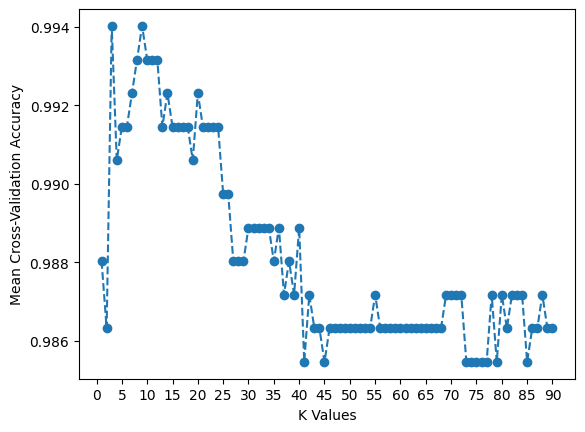

Best k Value:  3
Highest Accuracy:  0.994017094017094


In [40]:
### YOUR CODE HERE ###
from sklearn.preprocessing import StandardScaler
#Step 1: Standardize the Data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#Step 2: Building a KNN Model & Plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn_values = []
mean_scored = []
for k in range(1, 91):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x_train_scaled, y_train, cv=10, scoring='accuracy').mean()
    knn_values.append(k)
    mean_scored.append(score)

plt.plot(knn_values, mean_scored, linestyle='dashed', marker='o')
plt.xticks(range(0,91,5))
plt.xlabel("K Values")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.show()

#Step 3: Best k and Highest Crossvalidation
highest_accuracy = max(mean_scored)
index = mean_scored.index(highest_accuracy)
best_k = knn_values[index]
print("Best k Value: ", best_k)
print("Highest Accuracy: ", highest_accuracy)

**Best K Value** is 3 and **Highest Accuracy** is 99.4%

**Comment on which ranges of k lead to underfitted or overfitted models**

When [1 <= k < 25] K is overfitted, and when [40 <= k <= 90] K is underfitted.


### Feature Selection 
* The goal was to evaluate the importance of each feature on classification performance.

* Testing all feature combinations was infeasible due to the (2^F) search space and required hyperparameter tuning.

* A **decision tree** was used to estimate feature importance and rank features by relevance.

* The least important feature was removed, and a new **KNN model** was trained on the reduced feature set.

* This process was repeated until the stopping criteria were met, enabling efficient feature selection without exhaustive search.

In [41]:
### YOUR CODE HERE ###
from sklearn import tree
from sklearn import datasets
dt = tree.DecisionTreeClassifier()
dt.fit(x_train,y_train)
importance = dt.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00560
Feature: 1, Score: 0.00020
Feature: 2, Score: 0.00592
Feature: 3, Score: 0.11283
Feature: 4, Score: 0.03033
Feature: 5, Score: 0.84512



### Create the Feature_selector function

* A function, **`Feature_selector`**, was created to iteratively remove features while monitoring model performance.

* Inputs: **`X_train`**, **`y_train`**, and a **threshold** value.

* The function workflow:

  * Fit a **decision tree classifier** on the training set.
  * Extract the **feature importance ranking** from the decision tree.
  * Remove the **least important feature**.
  * Train a **KNN model** on the remaining features, tuning **k** using **5-fold cross-validation**.
  * Store:

    * The best **mean cross-validation accuracy** (after tuning)
    * The corresponding best **k** value
  * Repeat the remove → retrain → tune cycle.

* Stopping conditions:

  * Stop if only **one feature** remains, or
  * Stop if performance drops below **threshold × (full-feature CV accuracy)**

    * Example: threshold = 0.95 means stop once CV accuracy falls below 95% of the full-feature baseline.

* Output:

  * A list of **removed features**, along with the **mean cross-validation accuracy** and **best k** at each removal step.


In [42]:
### YOUR CODE HERE ###
def knn_and_score(x_train, y_train):
  knn_values = []
  mean_scored = []
  for k in range(1, 91):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy').mean()
    knn_values.append(k)
    mean_scored.append(score)

  highest_accuracy = max(mean_scored)
  index = mean_scored.index(highest_accuracy)
  best_k = knn_values[index]

  return best_k, highest_accuracy

def feature_selector(x_train, y_train, threshold):
  #define return arrays
  removed_features = []
  k_values = []
  mcva_values = []

  #define constant variables
  k, ff_mcva = knn_and_score(x_train, y_train) #full feature accuracy
  dt = tree.DecisionTreeClassifier()
  dt.fit(x_train,y_train)
  importance = dt.feature_importances_ #feature importance order
  x_train = pd.DataFrame(x_train) #modifiable dataset

  #define initial variables
  mcva = ff_mcva #initial mean cross validation accuracy
  x_mod = pd.DataFrame(x_train.copy()) #modifiable dataset
  importance_mod = importance.copy() #modifiable feature importance order

  #add ff values to arrays
  k_values.append(k)
  mcva_values.append(ff_mcva)

  #if the mcva is valid, accept removed feature
  #Stopping condition #1: only 1 feature left
  #Stopping condition #2: mcva < 0.95 * threshold

  while len(x_mod.columns) > 1:
    #find least important feature (index)
    least_important = importance_mod.argmin()

    #get the corresponding feature name
    feature = x_mod.columns[least_important]
    #print("Removing least important feature:", feature)

    #remove least important feature from both data and importance list
    x_mod = x_mod.drop(columns=[feature])
    importance_mod = np.delete(importance_mod, least_important)

    #check if accuracy valid
    best_k, mcva = knn_and_score(x_mod, y_train)
    if mcva < 0.95 * ff_mcva:
      break

    #add feature to removed and update other arrays
    removed_features.append(feature)
    k_values.append(best_k)
    mcva_values.append(mcva)

  return removed_features, k_values, mcva_values

#Function Testing
test1 = feature_selector(x_train_scaled, y_train, 0.95)
print(test1)

([0, 2, np.int64(1), np.int64(4), np.int64(3)], [3, 6, 3, 7, 5, 66], [np.float64(0.994017094017094), np.float64(0.994017094017094), np.float64(0.9923076923076923), np.float64(0.9914529914529915), np.float64(0.9897435897435898), np.float64(0.958119658119658)])



### Implement the Feature_selector function

* The **Feature_selector** function was applied to the **standardized training data** using a **95% threshold**.

* Results were visualized by:

  * Plotting **mean cross-validation accuracy vs. number of features**, showing performance from one feature up to the full feature set.
  * Plotting the **optimal value of k vs. number of features**, illustrating how neighborhood size changes as features are removed.

* From the accuracy plot, performance remained **stable (≈ 0.990–0.995)** when using **2–6 features**, with no meaningful improvement beyond this range.

* Based on this stability and model simplicity, the **essential number of features** for classification was identified as **2**.

* The **best observed accuracy** is recorded directly below the corresponding graph.

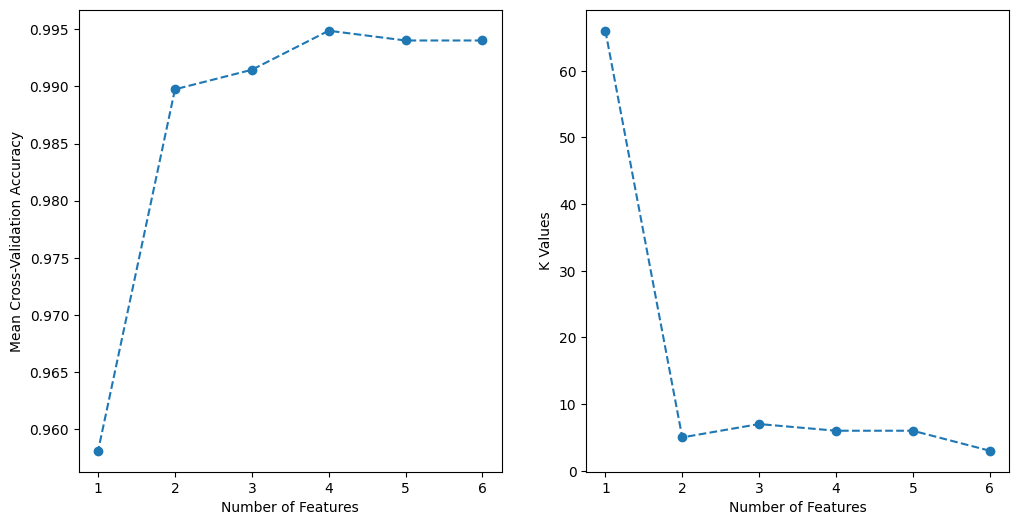

Best Accuracy after Feature Selection:  0.9948717948717949


In [43]:
### YOUR CODE HERE ###
#Step 1: Visualize mcva & features
removed_features, k_values, mcva_values = feature_selector(x_train_scaled, y_train, 0.95)
num_features = list(range(len(removed_features)+1, 0, -1))

#plot 1
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(num_features, mcva_values, linestyle='dashed', marker='o')
plt.xlabel("Number of Features")
plt.xticks(num_features)
plt.ylabel("Mean Cross-Validation Accuracy")

#Step 2: Select Features & Test on KNN
#plot 2
plt.subplot(1,2,2)
plt.plot(num_features, k_values, linestyle='dashed', marker='o')
plt.ylabel("K Values")
plt.xticks(num_features)
plt.xlabel("Number of Features")
plt.show()

#Print Accuracy and Features
best_accuracy = max(mcva_values)
print("Best Accuracy after Feature Selection: ", best_accuracy)

# Part C: Other Built-in Models & Hyperparameter Tuning

* In this section, multiple built-in classification models were trained using the **full feature set**, with **hyperparameter tuning** performed to maximize accuracy/scores.

* Since the full feature set was used, the Feature_selector step was no longer needed.

* The tuned models included:

  * Decision Tree
  * Random Forest
  * Bagged Trees
  * Gradient Boosted Trees
  * SVM (Polynomial kernel)
  * SVM (RBF kernel)

* Each model was evaluated after tuning, with results reported separately for comparison.



## Tree-based Models

### Decision Tree Classifier 

* A **Decision Tree classifier** was trained on the **standardized dataset** and tuned using **RandomizedSearchCV** to maximize mean cross-validated accuracy.

* The following hyperparameter ranges were searched:

  * `max_depth` sampled from 1 to 9
  * `min_samples_split` sampled from 2 to 49

* RandomizedSearchCV settings used:

  * `n_iter = 500`
  * `cv = 5`
  * `verbose = 2`
  * `random_state = 24`
  * `n_jobs = -1`
  * `return_train_score = True`

* After tuning, the best model was reported in the format:

  * **Best performance using decision tree is *[best mean CV accuracy]* with a max depth of *[best max_depth]* and a min samples split of *[best min_samples_split]*.**

In [44]:
### YOUR CODE HERE ###
#reimported to avoid changing previous cells
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#Define tree
dt = DecisionTreeClassifier()
tree_param_dist = {
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 50),
}

#Random Search CV
tree_rand_search = RandomizedSearchCV(dt, param_distributions=tree_param_dist, n_iter=500, cv=5, random_state=24, n_jobs=-1, return_train_score=True)
tree_rand_search.fit(x_train_scaled, y_train)
tree_best_accuracy = tree_rand_search.best_score_
tree_best_params = tree_rand_search.best_params_
print("Best Accuracy: ", tree_best_accuracy)
print("Best Hyperparameters: ", tree_best_params)

Best Accuracy:  0.9820512820512821
Best Hyperparameters:  {'max_depth': 9, 'min_samples_split': 3}


### Random Forests 

* A **Random Forest classifier** was trained on the **standardized full-feature dataset** and tuned using **RandomizedSearchCV** to maximize mean cross-validated accuracy.

* Hyperparameters tuned:

  * `max_features` in `['sqrt', 'log2', 0.1, 0.25, 0.5]`
  * `n_estimators` sampled from 10 to 199

* RandomizedSearchCV settings used:

  * `n_iter = 500`
  * `cv = 5`
  * `verbose = 2`
  * `random_state = 24`
  * `n_jobs = -1`

* After tuning, results were recorded and reported as:

  * **Best n_estimators: *[best n_estimators]*, Best Max Features: *[best max_features]*, Best Accuracy: *[best mean CV accuracy]***


In [45]:
### YOUR CODE HERE ###
#Define forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=24)
rfparam_dist = {
    'max_features' : ['sqrt', 'log2', 0.1, 0.25, 0.5],
    'n_estimators' : randint(10, 200)
}

#Random Search CV
rf_rand_search = RandomizedSearchCV(rf, param_distributions=rfparam_dist, n_iter=500, cv=5, random_state=24, n_jobs=-1)
rf_rand_search.fit(x_train_scaled, y_train)
rfbest_accuracy = rf_rand_search.best_score_
rfbest_params = rf_rand_search.best_params_
print("Best Accuracy: ", rfbest_accuracy)
print("Best Hyperparameters: ", rfbest_params)


Best Accuracy:  0.994017094017094
Best Hyperparameters:  {'max_features': 0.25, 'n_estimators': 92}


### Bagging (ensemble of bagged trees)

* A **Bagging classifier** was trained on the **standardized full-feature dataset**, with `max_features` set to the total number of available features.

* The model was evaluated using cross-validation while tuning the number of estimators:

  * `n_estimators ∈ {10, 50, 100, 250}`

* Model performance was compared across these settings, and the configuration with the highest mean cross-validated accuracy was selected.

* Results were reported as:

  * **Best n_estimators (Bagged Trees): *[best n_estimators]*, Best Accuracy (Bagged Trees): *[best mean CV accuracy]***



In [46]:
### YOUR CODE HERE ###
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

#Define forest
n_estimators = [10, 50, 100, 250]
tb_best_accuracy = 0
tb_best_params = 0

for n in n_estimators:
  tree_bag = BaggingClassifier(n_estimators=n, random_state=24, n_jobs=-1)
  tree_bag.fit(x_train_scaled, y_train)
  scores = cross_val_score(tree_bag, x_train_scaled, y_train, cv=5)
  accuracy = scores.mean()
  if accuracy > tb_best_accuracy:
    tb_best_accuracy = accuracy
    tb_best_params = n

print("Best Accuracy: ", tb_best_accuracy)
print("Best n_estimator: ", tb_best_params)

Best Accuracy:  0.9854700854700855
Best n_estimator:  250


### Gradient Boosting Classifier

* A **Gradient Boosting classifier** was trained on the **standardized full-feature dataset**.

* Hyperparameters were tuned using **GridSearchCV** with the following search space:

  * `learning_rate ∈ [0.082, 0.130, 0.099, 0.053, 0.007]`
  * `max_depth ∈ [1, 2, 3]`
  * `n_estimators ∈ [1, 10, 50, 100, 300, 500]`

* GridSearchCV settings used:

  * `cv = 5`
  * `verbose = 2`
  * `n_jobs = -1`

* After tuning, the best-performing configuration was reported as:

  * **Best n_estimators: *[best n_estimators]*, Best Learning Rate: *[best learning rate]*, Best Max Depth: *[best max depth]*, Best Accuracy: *[best mean CV accuracy]***


In [47]:
### YOUR CODE HERE ###
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(random_state=24)

gb_params = {
    'learning_rate' : [0.082, 0.130, 0.099, 0.053, 0.007],
    'max_depth' : [1,2,3],
    'n_estimators' : [1, 10, 50, 100, 300, 500]
}

gridsearch = GridSearchCV(gb, param_grid=gb_params, cv=5, verbose=2, n_jobs=-1)
gridsearch.fit(x_train_scaled, y_train)

gbbestparams = gridsearch.best_params_
gbbestaccuracy = gridsearch.best_score_

print("Best Parameters: ", gbbestparams)
print("Best Accuracy: ", gbbestaccuracy)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters:  {'learning_rate': 0.082, 'max_depth': 1, 'n_estimators': 300}
Best Accuracy:  0.9914529914529915


## Pact C-2: Hyperplane-based Models **[10 Marks Total]**

## SVM with Polynomial Kernel  

* An **SVM classifier with a polynomial kernel** (`kernel='poly'`) was trained on the **standardized full-feature dataset** and tuned using **RandomizedSearchCV** to maximize mean cross-validated accuracy.

* Hyperparameters tuned:

  * `C` sampled from `expon(scale=10)`
  * `degree` sampled from 2 to 5

* RandomizedSearchCV settings used:

  * `n_iter = 500`
  * `cv = 5`
  * `verbose = 2`
  * `random_state = 24`
  * `n_jobs = -1`

* After tuning, results were recorded and reported as:

  * **Best C: *[best C]*, Best degree: *[best degree]*, Best Accuracy: *[best mean CV accuracy]***

In [48]:
### YOUR CODE HERE ###
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, randint

svm = SVC(kernel='poly')

params = {
    'C': expon(scale=10),
    'degree': randint(2, 6)
}

svm_search = RandomizedSearchCV(svm, param_distributions=params, cv=5, n_iter = 500, verbose=2, random_state=24, n_jobs=-1)
svm_search.fit(x_train_scaled, y_train)

bestparams = svm_search.best_params_
bestaccuracy = svm_search.best_score_

print("Best Parameters: ", bestparams)
print("Best Accuracy: ", bestaccuracy)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters:  {'C': np.float64(4.844758649225441), 'degree': 3}
Best Accuracy:  0.9846153846153847


## Part C2.2: SVM with Radial Kernel **[5 Marks]**

Similarly train an SVM with radial kernel on the standardized full feature dataset (read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and check the example there.) with `rbf` as the kernel value. Tune the `C` and `gamma` parameters of the classifier using [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) with `n_iter = 500`.

set:

*  `'C': expon(scale=10)`
* `'gamma': ['scale', 'auto', 0.1, 1] `

For RandomizedSearchCV, use:

* `cv=5`,
* `verbose=2`,
* `random_state=24`,
* `n_jobs=-1`,

Record & print out:

* the highest  mean cross-validated accuracy/score, and
* the value of the hyperparameter you tuned, that achieved the highest accuracy/score.
* i.e: *Best C: 2, Best Gamma: scale, Best Accuracy: 0.98754321*


In [49]:
### YOUR CODE HERE ###
svmrbf = SVC(kernel='rbf')

rbfparams = {
    'C': expon(scale=10),
    'gamma': ['scale', 'auto', 0.1, 1]
}

rbfsvm_search = RandomizedSearchCV(svmrbf, param_distributions=rbfparams, cv=5, n_iter = 500, verbose=2, random_state=24, n_jobs=-1)
rbfsvm_search.fit(x_train_scaled, y_train)

rbfbestparams = rbfsvm_search.best_params_
rbfbestaccuracy = rbfsvm_search.best_score_

print("Best Parameters: ", rbfbestparams)
print("Best Accuracy: ", rbfbestaccuracy)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters:  {'C': np.float64(0.543026811257739), 'gamma': 'auto'}
Best Accuracy:  0.9931623931623932


# Part D: Model Accuracy

A table was created below to compare the hyperparameters and accuracies between the models.

In [51]:
### YOUR CODE HERE ###
import pandas as pd

model_comparison = {
    'Model': ["Decision Tree", "Random Forest", "Bagged Trees", "Gradient Boosted Trees", "SVM with Polynomial Kernel", "SVM with RBF Kernel", "Feature Selection"],
    'Accuracy': [tree_best_accuracy, rfbest_accuracy, tb_best_accuracy, gbbestaccuracy, bestaccuracy, rbfbestaccuracy, best_accuracy],
    'Best Hyperparameters': [tree_best_params, rfbest_params, tb_best_params, gbbestparams, bestparams, rbfbestparams, removed_features]
}

model_comparison = pd.DataFrame(model_comparison)
model_comparison.head(10)

,Model,Accuracy,Best Hyperparameters
0,Decision Tree,0.982051,"{'max_depth': 9, 'min_samples_split': 3}"
1,Random Forest,0.994017,"{'max_features': 0.25, 'n_estimators': 92}"
2,Bagged Trees,0.985470,250
3,Gradient Boosted Trees,0.991453,"{'learning_rate': 0.082, 'max_depth': 1, 'n_es..."
4,SVM with Polynomial Kernel,0.984615,"{'C': 4.844758649225441, 'degree': 3}"
5,SVM with RBF Kernel,0.993162,"{'C': 0.543026811257739, 'gamma': 'auto'}"
6,Feature Selection,0.994872,"[0, 1, 2, 4, 3]"


# Part E: Evaluation on Test Data


## Performance measures

* The **best-performing model**, based on cross-validated accuracy, was selected and applied to the **held-out test dataset**.

* The test features were standardized using the **scaler fitted on the training data**; the target labels were not standardized.

* Model performance on the test set was evaluated using:

  * **Accuracy**
  * **Precision**
  * **Recall**
  * **Fall-out rate (False Positive Rate)**
  * **F1 score**
  * **Confusion matrix**

* These metrics provide a comprehensive assessment of the model’s classification performance on unseen data.


In [59]:
### YOUR CODE HERE ###
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#finding highest accuracy model
max_model = model_comparison.loc[model_comparison['Accuracy'].idxmax(), 'Model']
print("Highest Accuracy Model is:", max_model)

#standardize
dt_scaler = StandardScaler()
x_train_scaled = dt_scaler.fit_transform(x_train)
x_test_scaled = dt_scaler.transform(x_test)

#model
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(x_train_scaled, y_train)
y_pred = dt_model.predict(x_test_scaled)

#calculations
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)


Highest Accuracy Model is: Feature Selection
Accuracy: 0.9795221843003413
Precision: 0.9798994974874372
Recall: 0.9898477157360406
F1 Score: 0.9848484848484849
Confusion Matrix:
 [[ 92   4]
 [  2 195]]
